In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

sys.path.append('..')

from torch import nn
from Utils.neuralnetworks import SigmoidNeuralNetwork
from Utils.utils import load_data, run_multiple_nn, run_multiple_forest, run_multiple_logistics
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Define Paramaters

In [2]:
base_seed = 42
base_feature_size = 15
baseline_accuracy = 0.9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Neural Network

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=False)

### Performing grid search

In [ ]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
    train_split=None
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [1024],
    'module__layer_size': [32, 64],
    'module__layer_no': [1],
    'optimizer__weight_decay': [1e-3, 1e-4],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [5]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 1024, 'max_epochs': 50, 'module__layer_no': 1, 'module__layer_size': 64, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.9624166666666666


### Assesing performance

In [6]:
nn_results = run_multiple_nn(gs, base_feature_size=base_feature_size, device=device, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.9426666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.9396666666666667
Run 3 / 10 started
Run finished with test accuracy: 0.9368333333333333
Run 4 / 10 started
Run finished with test accuracy: 0.9475
Run 5 / 10 started
Run finished with test accuracy: 0.9386666666666666
Run 6 / 10 started
Run finished with test accuracy: 0.9435
Run 7 / 10 started
Run finished with test accuracy: 0.9456666666666667
Run 8 / 10 started
Run finished with test accuracy: 0.9305
Run 9 / 10 started
Run finished with test accuracy: 0.9438333333333333
Run 10 / 10 started
Run finished with test accuracy: 0.9516666666666667


In [7]:
print(nn_results.head())

os.makedirs('results', exist_ok=True)
nn_results.to_csv(f'results/nn_results_{base_feature_size}.csv')

   Seed  epoch  train_loss  train_accuracy  test_accuracy
0     0      0    0.697601        0.502875       0.942667
1     0      1    0.691775        0.520833       0.942667
2     0      2    0.689906        0.539417       0.942667
3     0      3    0.678716        0.586000       0.942667
4     0      4    0.623874        0.630375       0.942667


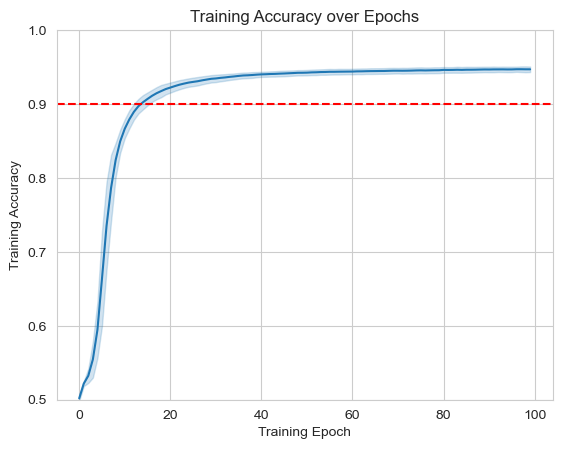

In [8]:
sns.set_style("whitegrid")
ax = sns.lineplot(data=nn_results, x='epoch', y='train_accuracy', errorbar='sd')
ax.set(xlabel='Training Epoch', ylabel='Training Accuracy', ylim=(0.5, 1.0), title='Training Accuracy over Epochs')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--')
plt.show()

# Random Forrests

In [9]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Assessing Performance

In [10]:
forrest_results = run_multiple_forest(base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.965
Run 2 / 10 started
Run finished with test accuracy: 0.9696666666666667
Run 3 / 10 started
Run finished with test accuracy: 0.967
Run 4 / 10 started
Run finished with test accuracy: 0.9676666666666667
Run 5 / 10 started
Run finished with test accuracy: 0.962
Run 6 / 10 started
Run finished with test accuracy: 0.9658333333333333
Run 7 / 10 started
Run finished with test accuracy: 0.9666666666666667
Run 8 / 10 started
Run finished with test accuracy: 0.9666666666666667
Run 9 / 10 started
Run finished with test accuracy: 0.9658333333333333
Run 10 / 10 started
Run finished with test accuracy: 0.9683333333333334


In [11]:
print(forrest_results)

os.makedirs('results', exist_ok=True)
forrest_results.to_csv(f'results/rf_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.965000
1    1       0.969667
2    2       0.967000
3    3       0.967667
4    4       0.962000
5    5       0.965833
6    6       0.966667
7    7       0.966667
8    8       0.965833
9    9       0.968333


In [12]:
print("Random Forest Accuracy:", forrest_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Random Forest Accuracy: 0.9664666666666667
Baseline to beat 0.9


# Logistic Regression

In [3]:
X_train, y_train, _, _, feature_size  = load_data(base_seed, base_feature_size, discreteize=True, expand=True)

### Performing Grid Search

In [4]:
params = {
    'alpha': [0.1, 0.15, 0.2],
    'max_iter': [1500],
    'tol': [1e-3],
    'learning_rate': ['optimal', 'constant'],
    'eta0': [0.01, 0.001],
}

logreg = SGDClassifier(loss='log_loss', n_jobs=-1)

gs = GridSearchCV(logreg, params, refit=False, cv=10, scoring='accuracy', n_jobs=2, verbose=1)
clf = gs.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


KeyboardInterrupt: 

In [ ]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 1500, 'tol': 0.001}
Best accuracy found:  0.5519270833333334


### Assessing Performance

In [ ]:
logreg_results = run_multiple_logistics(gs, base_feature_size, no_runs=10)

Run 1 / 10 started
Run finished with test accuracy: 0.5541666666666667
Run 2 / 10 started
Run finished with test accuracy: 0.5397916666666667
Run 3 / 10 started
Run finished with test accuracy: 0.5627083333333334
Run 4 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 5 / 10 started
Run finished with test accuracy: 0.5583333333333333
Run 6 / 10 started
Run finished with test accuracy: 0.5445833333333333
Run 7 / 10 started
Run finished with test accuracy: 0.5308333333333334
Run 8 / 10 started
Run finished with test accuracy: 0.535625
Run 9 / 10 started
Run finished with test accuracy: 0.5514583333333334
Run 10 / 10 started
Run finished with test accuracy: 0.5375


In [ ]:
print(logreg_results)

os.makedirs('results', exist_ok=True)
logreg_results.to_csv(f'results/log_results_{base_feature_size}.csv')

   run  test_accuracy
0    0       0.554167
1    1       0.539792
2    2       0.562708
3    3       0.551458
4    4       0.558333
5    5       0.544583
6    6       0.530833
7    7       0.535625
8    8       0.551458
9    9       0.537500


In [ ]:
print("Logistic Regression Accuracy:", logreg_results['test_accuracy'].mean())
print("Baseline to beat", baseline_accuracy)

Logistic Regression Accuracy: 0.5466458333333333
Baseline to beat 0.925
